# Solving ODEs with SciPy

#### Examples
* [Pendulum](#Pendulum)
* [Exponential decay](#Exponential-decay)
* [Cannon](#Cannon-firing-upwards)
* [Chemical reaction](#Chemical-kinetic-reaction)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
%load_ext watermark
%watermark -p numpy,matplotlib,scipy

numpy 1.17.2
matplotlib 3.1.1
scipy 1.1.0


## Pendulum

The second order differential equation for the angle $\theta$ of a pendulum acted on by gravity with friction can be written:
$\theta'' + b \theta' + c \sin(\theta) = 0$

To solve this with odeint, we must first convert it to a system of first order equations:
\begin{align}
\theta'(t) &= \omega(t) \\
\omega'(t) &= -b \omega(t) - c \sin(\theta(t))
\end{align}

Defining $y = (\theta, \omega)$ we can implement this as

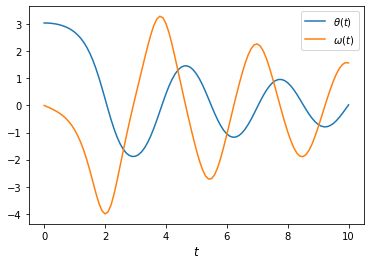

In [2]:
def pendulum(y, t, b, c):
    """dy/dt for a pendulum"""
    θ, ω = y
    return [ω, -b * ω - c * np.sin(θ)]

b = 0.25
c = 5
y0 = [np.pi - 0.1, 0.0]  # initial conditions
t = np.linspace(0, 10, 101)  # timesteps

sol = odeint(pendulum, y0, t, args=(b, c))

plt.plot(t, sol)
plt.legend([r'$\theta(t)$', r'$\omega(t)$'])
plt.xlabel('$t$');

Using `solve_ivp`, the function dy/dt = f(t, y) without extra arguments needs to be provided. By default the function picks the evaluation steps itself, but we can optionally provide the points where the solution should be evaluated.

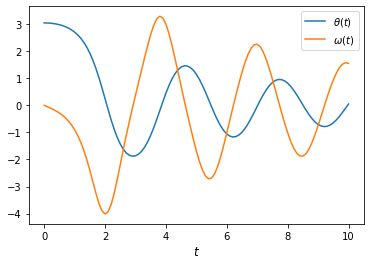

In [3]:
b = 0.25
c = 5

def pendulum(t, y):
    θ, ω = y
    return [ω, -b * ω - c * np.sin(θ)]

sol = solve_ivp(
    pendulum,
    y0=[np.pi - 0.1, 0.0],
    t_span=(0, 10),
    t_eval=np.linspace(0, 10, 101)
)

plt.plot(sol.t, sol.y.T)
plt.legend([r'$\theta(t)$', r'$\omega(t)$'])
plt.xlabel('$t$');

## Exponential decay

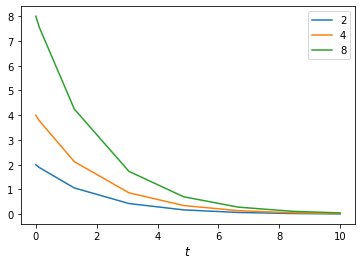

In [4]:
def exponential_decay(t, y): return -0.5 * y
y0 = [2, 4, 8]
sol = solve_ivp(exponential_decay, t_span=[0, 10], y0=y0)

plt.plot(sol.t, sol.y.T)
plt.legend(y0)
plt.xlabel('$t$');

## Cannon firing upwards
Don't do that at home ...

We're shooting a projectile vertically upwards
\begin{align}
x'(t) &= v \\
v'(t) &= -g \\
y &= (x, v)
\end{align}
starting at $x(0) = 0\,$m with velocity $v(0)=100\,$m/s. The trajectory ends when it touches ground again. We implement this as an event with a terminal condition. Note that the integration never reaches $t=100\,$s because it is terminated before.

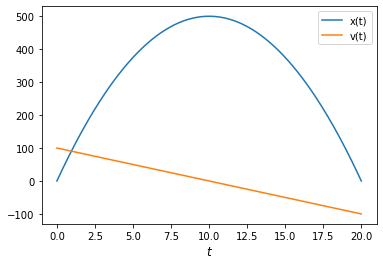

In [5]:
g = 10  # m/s²
def upward_cannon(t, y):
    return [y[1], -g]
def hit_ground(t, y): return y[0]  # an event function; each 0 triggers an event
hit_ground.terminal = True  # make the event terminate the integration
hit_ground.direction = -1

sol = solve_ivp(
    upward_cannon, 
    t_span=[0, 100],
    t_eval=np.linspace(0, 100, 1001),
    y0=[0, 100], 
    events=hit_ground
)

plt.plot(sol.t, sol.y.T)
plt.legend(['x(t)', 'v(t)'])
plt.xlabel('$t$');

In order to find the maximum height, we register an additional event for the point where the velocity is 0. By setting `dense_output=True` the returned solution has a callable `sol` attribute. 

In [6]:
def apex(t,y): return y[1]
sol = solve_ivp(
    upward_cannon, 
    t_span=[0, 100],
    y0=[0, 100], 
    events=(hit_ground, apex), 
    dense_output=True)
print(sol.t_events)
y_apex = sol.sol(sol.t_events[1][0])
print(f'Maximum height: {y_apex[0]:.1f} m' )

[array([20.]), array([10.])]
Maximum height: 500.0 m


## Chemical kinetic reaction

We have a chemical reaction $A \rightarrow B \rightarrow C$ described by the following ODE system:
\begin{align}
A'(t) &= - k_1 \cdot A(t) \\
B'(t) &= k_1 \cdot A(t) - k_2 \cdot B(t) \\
C'(t) &= k_2 \cdot B(t)
\end{align}
We can formulate this as a matrix product of the corresponding stochiometric matrix $S_m$ and the (vector of) rates for each reaction.

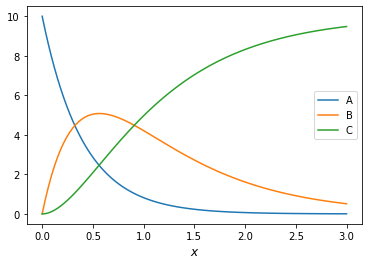

In [7]:
k1 = 2.5
k2 = 1.2
Sm = np.array([
    [-1, 1, 0],
    [0, -1, 1]
])

def dydt(t, y):
    rates = np.array([
        k1 * y[0],
        k2 * y[1]
    ])
    return Sm.T @ rates

sol = solve_ivp(dydt, y0=[10, 0, 0], t_span=(0, 3), t_eval=np.linspace(0, 3, 100))
plt.plot(sol.t, sol.y.T)
plt.legend(('A', 'B', 'C'))
plt.xlabel('$x$');